### Fifa 22 Complete Player df_mainset [UPD:01/10/21]

##### Content

Replaced positions that do not exist in fifa, for example ["LS", "RS"] with "ST".
And a few more brief introductory notes:

- monetary values in Euro;
- height in cm;
- weight in kg;
- players without clubs in the Clubs column - "Free agent"
- players who are not include to national teams in the column "NationalTeam" - "Not in team"

---

##### Hypotesis
- **Hypothesis 1**: Players with higher potential ratings are typically younger and command a higher market value.
- **Hypothesis 2**: The overall rating of a player is strongly correlated with their market value and wage.

- **Question 1**: Which players have the highest growth potential and could represent high-value acquisitions for clubs looking to invest in future talent?
- **Question 2**: What are the key attributes that differentiate high-value players from lower-value players?
- **Question 3**: How does a player's physical attributes, such as height and weight, correlate with their overall and potential ratings?



In [80]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
df = pd.read_csv('players_fifa22.csv')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19260 entries, 0 to 19259
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 19260 non-null  int64  
 1   Name               19260 non-null  object 
 2   FullName           19260 non-null  object 
 3   Age                19260 non-null  int64  
 4   Height             19260 non-null  int64  
 5   Weight             19260 non-null  int64  
 6   PhotoUrl           19260 non-null  object 
 7   Nationality        19260 non-null  object 
 8   Overall            19260 non-null  int64  
 9   Potential          19260 non-null  int64  
 10  Growth             19260 non-null  int64  
 11  TotalStats         19260 non-null  int64  
 12  BaseStats          19260 non-null  int64  
 13  Positions          19260 non-null  object 
 14  BestPosition       19260 non-null  object 
 15  Club               19260 non-null  object 
 16  ValueEUR           192

In [83]:
df.isna().sum().sort_values(ascending=False)

NationalNumber       18503
NationalPosition     18503
ClubNumber              76
ContractUntil           76
ClubPosition            76
                     ...  
DefensiveWorkRate        0
AttackingWorkRate        0
SkillMoves               0
WeakFoot                 0
GKRating                 0
Length: 90, dtype: int64

In [84]:
df_main = df.copy()
df_main = df_main.loc[:, ['Age', 'Height', 'Weight', 'Overall', 'Potential', 'Growth', 'BaseStats', 'TotalStats', 'ValueEUR', 'WageEUR', 'PreferredFoot']]
df_main.isna().sum().sort_values(ascending=False)

Age              0
Height           0
Weight           0
Overall          0
Potential        0
Growth           0
BaseStats        0
TotalStats       0
ValueEUR         0
WageEUR          0
PreferredFoot    0
dtype: int64

In [85]:
#df_main.head(20).to_json('players_fifa22_main_20.json', orient='records')
# convert 'PreferredFoot' to binary
print(df_main['PreferredFoot'].unique())
df_main['PreferredFoot'] = df_main['PreferredFoot'].map({'Left': 0, 'Right': 1})

['Left' 'Right']


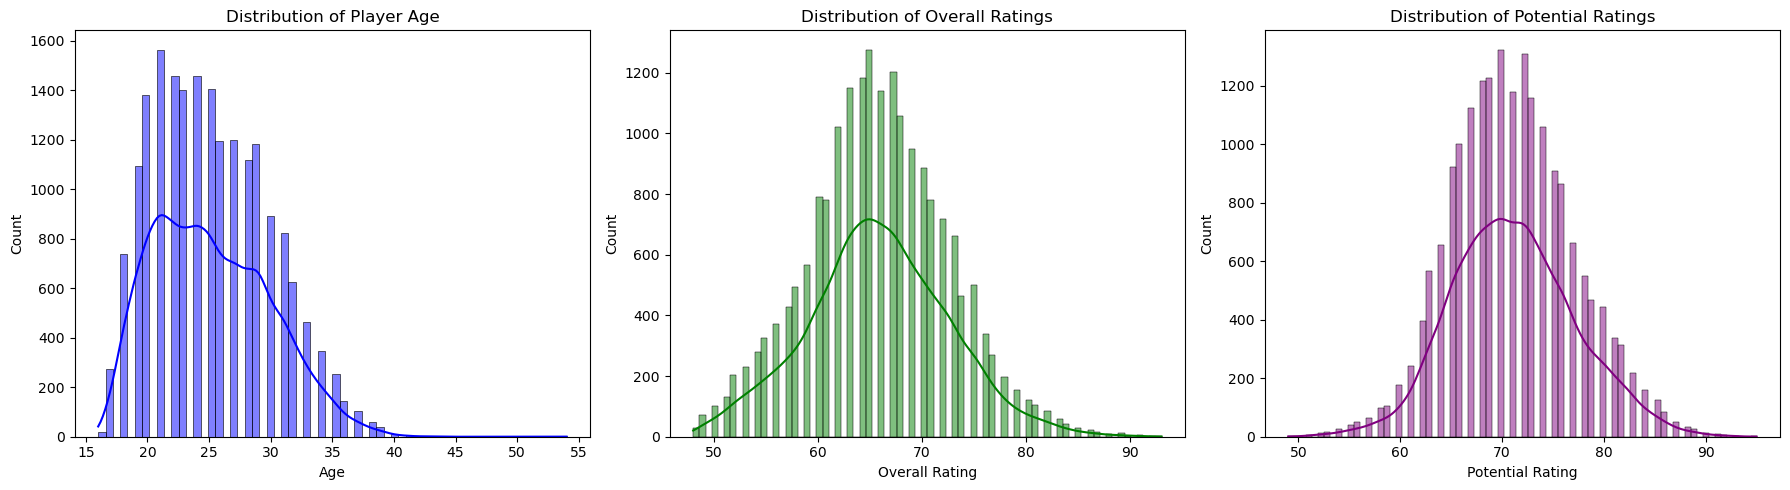

In [ ]:

# Plot distribution of Age, Overall, and Potential
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_main['Age'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Player Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

sns.histplot(df_main['Overall'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Overall Ratings')
axes[1].set_xlabel('Overall Rating')

sns.histplot(df_main['Potential'], kde=True, ax=axes[2], color='purple')
axes[2].set_title('Distribution of Potential Ratings')
axes[2].set_xlabel('Potential Rating')

plt.tight_layout()
plt.show()


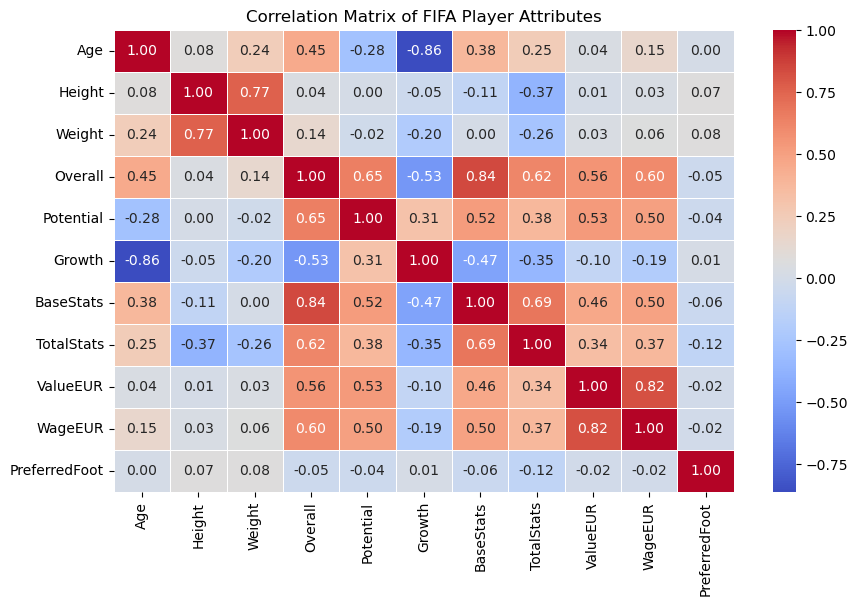

In [ ]:
corr_matrix = df_main.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of FIFA Player Attributes')
plt.show()